# Machine Learning Operations (MLOps)
## From "mlflow_task.ipynb" February 26, 2025
(use tensor_requirements.txt)

i. First, one is in the notebook - ‘mlflow_task.ipynb’. Complete all the tasks in this
notebook.

In this exercise, do the following:
1. Load the dataset used in the time series example - Energy consumption data. You can find it in the notebook "TSA_Example" in Time Series folder in Moodle.
2. Setup a nested MLFlow loop where different modelling experiments can be tracked and the use the dataset in point 1 to experiment and track models. You should do following combinations:
    1. At least 3 model types
    2. At least 3 different feature combinations
    3. At least 3 different options for 3 different hyperparameters
    4. At least 3 different time splits for train test
3. For each option in the combination, you should calculate & log the following in MLFlow:
    1. RMSE
    2. MAE
    3. Plot of actual vs predicted for 1 month data
    4. Plot of actual vs predicted for 1 week of data
    5. All of the combination info in point 2, such as which model, what feature combindation, what hyperparameter, what train test split has been used
4. Turn on MLFlow UI and track your experiments

In [1]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import time, subprocess 
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import IPython.display as display
from sklearn.metrics import mean_absolute_error, mean_squared_error


c:\Users\Hassan\miniconda3\envs\tensorvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
kagglehub.dataset_download("robikscube/hourly-energy-consumption")
file_path = "C:\\Users\\Hassan\\.cache\\kagglehub\\datasets\\robikscube\\hourly-energy-consumption\\versions\\3\\PJME_hourly.csv"
data = pd.read_csv(file_path)

In [3]:
#dropping duplicates
data = data.drop_duplicates(subset="Datetime")


In [4]:
#setting DateTime as index, making sure its in datetime format and sorting after the index to get chronological data
data = data.set_index("Datetime")
data.index = pd.to_datetime(data.index)
data  = data.sort_index()

In [5]:
#to identify missing timestamps
#create a range of timestamps hourly frequency h as our data is
ts_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq="h")
#differnce between the timestamp range and index of our dataframe will contain any missing time stamps
missing_timestamps = ts_range.difference(data.index)
missing_timestamps


DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

In [6]:
#adding the range to df
data = data.reindex(ts_range)
data.loc["2005-04-03 00:00:02":"2005-04-03 05:00:00"]

,PJME_MW
2005-04-03 01:00:00,24484.0
2005-04-03 02:00:00,23740.0
2005-04-03 03:00:00,NaN
2005-04-03 04:00:00,23414.0
2005-04-03 05:00:00,23289.0


In [11]:
#fill these by linear interpolation
data = data.interpolate(method='linear')
data.loc["2005-04-03 00:00:00":"2005-04-03 012:00:00"]

,PJME_MW
2005-04-03 00:00:00,26070.0
2005-04-03 01:00:00,24484.0
2005-04-03 02:00:00,23740.0
2005-04-03 03:00:00,23577.0
2005-04-03 04:00:00,23414.0
2005-04-03 05:00:00,23289.0
2005-04-03 06:00:00,23745.0
2005-04-03 07:00:00,24530.0
2005-04-03 08:00:00,25319.0
2005-04-03 09:00:00,26798.0


In [12]:
# extracting specific components from the datetime index
data["hour"] = data.index.hour
data["day"] = data.index.day
data["month"] = data.index.month
data["weekday"] = data.index.weekday


data.head(5)

,PJME_MW,hour,day,month,weekday
2002-01-01 01:00:00,30393.0,1,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1


# 2. Setup a nested MLFlow loop where different modelling experiments can be tracked and the use the dataset in point 1 to experiment and track models. You should do following combinations:
    1. At least 3 model types
    2. At least 3 different feature combinations
    3. At least 3 different options for 3 different hyperparameters
    4. At least 3 different time splits for train test

In [ ]:
models = {
    "LinearRegression": LinearRegression,
    "RandomForest": RandomForestRegressor,
    "XGBoost": XGBRegressor
}
feature_combinations = [
    ["hour", "day", "month", "weekday"],
    ["hour", "day", "month"],
    ["hour", "day", "weekday"],
]
hyperparams = {
    "n_estimators": [50],
    "max_depth": [5],
    "learning_rate": [0.01]
}


# creating training split by seasonal equinox/solsice
seasons = {
    'Spring': pd.Timestamp(year=data.index.year.min(), month=3, day=21),
    'Summer': pd.Timestamp(year=data.index.year.min(), month=6, day=21),
    'Fall': pd.Timestamp(year=data.index.year.min(), month=9, day=21),
    'Winter': pd.Timestamp(year=data.index.year.min(), month=12, day=21)
}
split_points = [seasons[season] for season in seasons]


# 3. For each option in the combination, you should calculate & log the following in MLFlow:
    1. RMSE
    2. MAE
    3. Plot of actual vs predicted for 1 month data
    4. Plot of actual vs predicted for 1 week of data
    5. All of the combination info in point 2, such as which model, what feature combindation, what hyperparameter, what train test split has been used

# 3. For each option in the combination, you should calculate & log the following in MLFlow:
    1. RMSE
    2. MAE
    3. Plot of actual vs predicted for 1 month data
    4. Plot of actual vs predicted for 1 week of data
    5. All of the combination info in point 2, such as which model, what feature combindation, what hyperparameter, what train test split has been used

In [16]:
# Start MLflow experiment
mlflow.set_experiment("MLOPS_2")

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name): 
        for features in feature_combinations:
            feature_name = "-".join(features)
            for n_estimators in hyperparams["n_estimators"]:
                for max_depth in hyperparams["max_depth"]:
                    for learning_rate in hyperparams["learning_rate"]:
                        for split_point in split_points:
                            child_run_name = f"{feature_name}| n_est={n_estimators}| depth={max_depth}| lr={learning_rate}| time_split_point={split_point}"
                            with mlflow.start_run(run_name=child_run_name, nested=True):

                                X = data[features]
                                y = data["PJME_MW"]

                                # For X_train, slice until (excluding split_point)
                                X_train, X_test = X[:split_point], X[split_point:]
                                y_train, y_test = y[:split_point], y[split_point:]

                                # Model training and hyperparameter tuning using validation set
                                if model_name == "LinearRegression":
                                    model = LinearRegression(n_jobs=-1)
                                elif model_name == "RandomForest":
                                    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
                                elif model_name == "XGBoost":
                                    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, n_jobs=-1)

                                model.fit(X_train, y_train)

                                y_test_pred = model.predict(X_test)

                                # Metrics on the test set
                                rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
                                mae_test = mean_absolute_error(y_test, y_test_pred)

                                # Log test metrics
                                mlflow.log_metric('RMSE_test', rmse_test)
                                mlflow.log_metric('MAE_test', mae_test)

                                # Log params
                                mlflow.log_param('model', model_name)
                                mlflow.log_param('features', feature_name)
                                mlflow.log_param('n_estimators', n_estimators)
                                mlflow.log_param('max_depth', max_depth)
                                mlflow.log_param('learning_rate', learning_rate)
                                mlflow.log_param('split_point', split_point)

                                # Log the model
                                mlflow.sklearn.log_model(model, model_name)

                                # Plots for 1 week and 1 month on the test set
                                plt.figure(figsize=(8, 6))
                                plt.plot(y_test.index[:24*7], y_test[:24*7], label='Actual')
                                plt.plot(y_test.index[:24*7], y_test_pred[:24*7], label='Predicted')
                                plt.xlabel('Time')
                                plt.ylabel('Energy Consumption')
                                plt.title('1 Week - Actual vs Predicted')
                                plt.xticks(rotation=25, ha='right')
                                plt.legend()
                                plt.savefig('1_week_plot.png')
                                mlflow.log_artifact('1_week_plot.png')
                                plt.close()

                                plt.figure(figsize=(8, 6))
                                plt.plot(y_test.index[:24*30], y_test[:24*30], label='Actual')
                                plt.plot(y_test.index[:24*30], y_test_pred[:24*30], label='Predicted')
                                plt.xlabel('Time')
                                plt.ylabel('Energy Consumption')
                                plt.title('1 Month - Actual vs Predicted')
                                plt.xticks(rotation=25, ha='right')
                                plt.legend()
                                plt.savefig('1_month_plot.png')
                                mlflow.log_artifact('1_month_plot.png')
                                plt.close()

print('Experiment completed. Check MLflow UI for details.')

# To start MLflow UI, run this in terminal:
# mlflow ui


2025/03/13 12:18:10 INFO mlflow.tracking.fluent: Experiment with name 'MLOPS_2' does not exist. Creating a new experiment.
2025/03/13 12:18:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/13 12:18:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/13 12:18:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/13 12:18:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/13 12:18:34 WARNING mlflow.models.model: Model logged without a signature and input e

Experiment completed. Check MLflow UI for details.


In [15]:
# Start MLFlow UI from the notebook
print("\nStarting MLFlow UI...")
process = subprocess.Popen(["mlflow", "ui", "--port", "5000"])  # Starts MLFlow UI on port 5000

# Wait a moment to ensure the server starts
time.sleep(3)

# Display a link to the MLFlow UI
display.display(display.Markdown("[Open MLFlow UI](http://localhost:5000)"))

print("MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.")


Starting MLFlow UI...


[Open MLFlow UI](http://localhost:5000)

MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.


So this is the pipeline parallel cordinate plot from the 3 methods, feature-combinations and hyperparams selected above.

The model with the lowest MAE and RMSE values is a RandomForrest model with the following details
-    Features: hour-day-month-weekday
-    Learning Rate: 0.01
-    Max Depth: 5
-    Model: RandomForest
-    N Estimators: 50
-    Split Point: 2002-12-21 00:00:00
-    MAE_test: 3180.6: 
-    RMSE_test: 4206.5


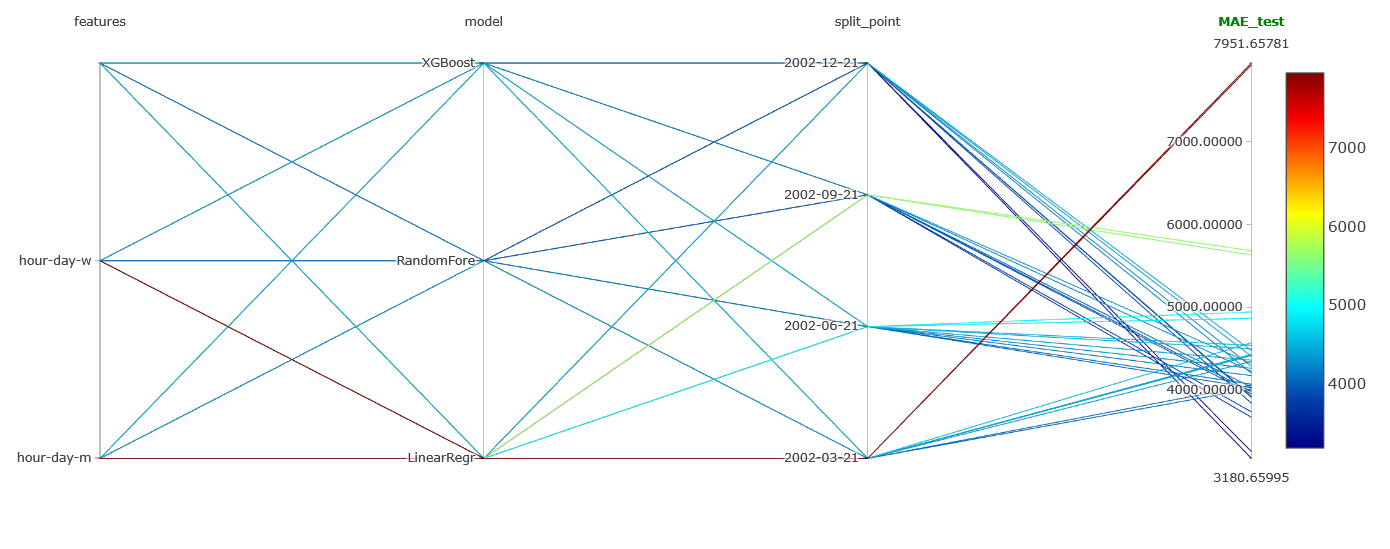

While not perfect, it is capturing most of the variation in the actual data.


<img src="bestmodel/1_month_plot.png" alt="1mo" width="400" height="300">
<img src="bestmodel/1_week_plot.png" alt="1we" width="400" height="300">
